In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

### 生成训练集

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.from_numpy(np.random.normal(0,1,(num_examples, num_inputs)))
labels =  true_w[0] * features[:, 0]  + true_w[1] * features[:, 1] +true_b
labels += torch.from_numpy(np.random.normal(0,  0.0001 , size=labels.size()))
features = features.float()
labels = labels.float()

In [3]:
print(features[0], labels[0])

tensor([-0.0241,  0.3940]) tensor(2.8121)


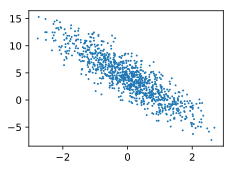

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

In [5]:
def data_iter(batch_size, features,labels):
    num_examples = len(labels)
    num_batch = num_examples // batch_size +1
    indices = list (range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.3001, -1.7822],
        [-1.7662, -0.1771],
        [ 0.8770,  1.0576],
        [-0.3544,  0.7682],
        [ 0.8777, -1.5310],
        [-0.3942,  0.7996],
        [ 0.0326,  0.3777],
        [-0.2765, -1.2388],
        [ 1.2875, -2.2572],
        [-0.3282, -0.1835]]) tensor([10.8599,  1.2698,  2.3580,  0.8796, 11.1609,  0.6926,  2.9809,  7.8590,
        14.4495,  4.1673])


In [37]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [38]:
w

tensor([[ 0.0112],
        [-0.0030]])

In [39]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`mm`函数做矩阵乘法。




In [40]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [41]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size()))**2/2

## 3.2.6 定义优化算法

以下的`sgd`函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。


In [42]:
def sgd(params,  lr , batch_size):
    for param in params:
        param.data -= lr * param.grad/batch_size

## 3.2.7 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失`l`的形状为(10, 1)。回忆一下自动求梯度一节。由于变量`l`并不是一个标量，所以我们可以调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [43]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range (num_epochs):
    for X,y in data_iter(batch_size, features,labels):
        L = loss (net(X, w, b), y ).sum()
        L.backward()
        sgd([w, b], lr, batch_size)
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_L = loss(net(features,w,b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_L.mean().item()))



epoch 1, loss 0.037310
epoch 2, loss 0.000085
epoch 3, loss 0.000000
